# Relativistic average GAN for MNIST

## Imports

In [1]:
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from viz import updatable_display2

import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

from generators import GumbelAttRNNGenerator
from discriminators import GumbelAttRNNDiscriminator
from utils import img2vec,vec2img,sample_noise,true_target,fake_target,onehot,num_parameters

from timeSeries import Sinusoids
from visualize import plotSamples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


## Dataset loading

In [2]:
batch_size = 128
num_steps = 16
dataset_size = 10000
num_classes = 10

data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size,quantization=num_classes),batch_size=batch_size,shuffle=True)
valid_data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size,quantization=num_classes),batch_size=batch_size,shuffle=True)

## Training setup

In [3]:
m = int(np.sqrt(batch_size))-1 # the sqrt of number of test samples
lr = 1e-4
dropout_prob = 0.3
noise_dim = 100
output_size = num_classes

num_test_samples = m**2
test_noise = sample_noise(num_test_samples,noise_dim,device)

# intialize models
generator = GumbelAttRNNGenerator(input_size=noise_dim,hidden_size=256,output_size=output_size,device=device).to(device)
discriminator = GumbelAttRNNDiscriminator(input_size=output_size,hidden_size=256,num_layers=2).to(device)

# otpimizers
g_optimizer = optim.Adam(generator.parameters(),lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(),lr=lr)
loss_fun = nn.BCEWithLogitsLoss()

# Create logger instance
dis = updatable_display2(['train'],["epoch","d_error","g_error"])
# Total number of epochs to train
num_epochs = 200
global_step = 0
epoch = 0
d_error = 0
g_error = 0


np_g = num_parameters(generator)
np_d = num_parameters(discriminator)
print("Number of parameters for G: {}\nNumber of parameters for D: {}\nNumber of parameters in total: {}"
      .format(np_g,np_d,np_g+np_d))

Number of parameters for G: 2139497
Number of parameters for D: 1926282
Number of parameters in total: 4065779


### Train Generator

In [4]:
def train_generator(real_data,fake_data,optimizer):
    '''
    Train the generator to generate realistic samples and thereby fool the discriminator
    '''
    N = fake_data.size(0)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    c_x_r = discriminator(real_data)

    # 1.2 Train on Fake Data
    c_x_f = discriminator(fake_data)
    
    # compute the average of c_x_*
    c_x_r_mean = torch.mean(c_x_r,dim=0)
    c_x_f_mean = torch.mean(c_x_f,dim=0)
    
    
    loss_real = loss_fun(c_x_r-c_x_f_mean,fake_target(N,device))
    loss_fake = loss_fun(c_x_f-c_x_r_mean,true_target(N,device))
    
    loss = (loss_real + loss_fake)/2.0
    loss.backward()
    
    optimizer.step()
    return loss

### Train Discriminator

In [5]:
def train_discriminator(real_data,fake_data,optimizer):
    '''
    Train the discriminator to distinguish between real and fake data
    '''
    N = real_data.size(0)
    
    # Reset gradients
    optimizer.zero_grad()

    # 1.1 Train on Real Data
    c_x_r = discriminator(real_data)

    # 1.2 Train on Fake Data
    c_x_f = discriminator(fake_data)
    
    # compute the average of c_x_*
    c_x_r_mean = torch.mean(c_x_r,dim=0)
    c_x_f_mean = torch.mean(c_x_f,dim=0)
        
    loss_real = loss_fun(c_x_r-c_x_f_mean,true_target(N,device))
    loss_fake = loss_fun(c_x_f-c_x_r_mean,fake_target(N,device))
    
    loss = (loss_real + loss_fake)/2.0
    loss.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    return loss

## Train the model

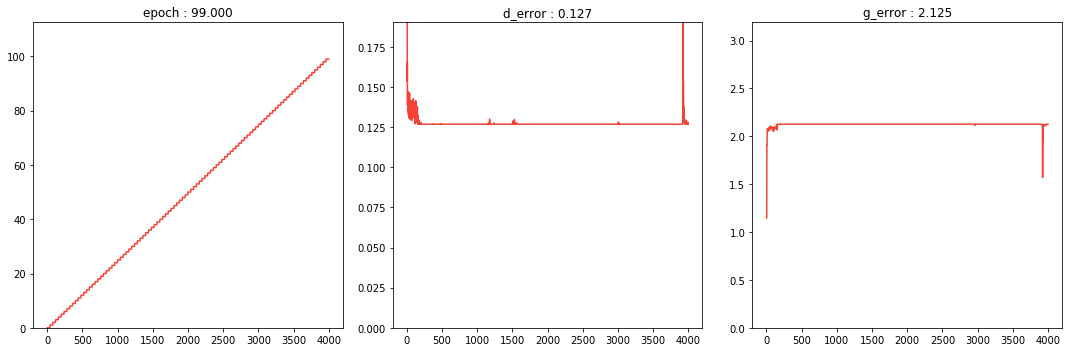

<Figure size 432x288 with 0 Axes>

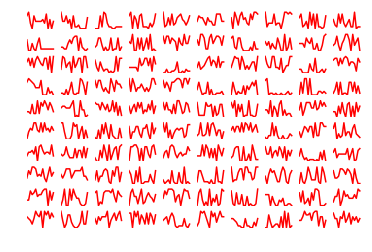

In [6]:
gen_steps = 1
gen_train_freq = 5
temperatures = torch.linspace(start=5,end=1,steps=int(num_epochs/2),device=device)

try:
    while epoch < num_epochs:
        if epoch <= int(num_epochs/2):
            temperature = temperatures[epoch]
        else:
            temperature = temperatures[-1]
        for n_batch,real_batch in enumerate(data_loader):
            N = real_batch.size(0)
            # 1. Train Discriminator
            real_batch = onehot(real_batch.squeeze(2),num_classes).type(torch.FloatTensor)
            real_data = real_batch.to(device)
            
            # Generate fake data and detach 
            # (so gradients are not calculated for generator)
            noise_tensor = sample_noise(N,noise_dim,device)
            with torch.no_grad():
                fake_data = generator(noise_tensor,num_steps,temperature).detach()
            # Train D
            d_error = train_discriminator(real_data,fake_data,d_optimizer)

            # 2. Train Generator every 'gen_train_freq' steps
            if global_step % gen_train_freq == 0:
                for _ in range(gen_steps):
                    # Generate fake data
                    fake_data = generator(sample_noise(N,noise_dim,device),num_steps,temperature)
                    # Train G
                    g_error = train_generator(real_data,fake_data,g_optimizer)
                    g_error = g_error.item()

            # Log batch error and delete tensors
            dis.update(global_step,'train',{"epoch":epoch,"d_error":d_error.item(),"g_error":g_error} )
            global_step += 1
            del fake_data
            del real_data
            del noise_tensor

            # Display Progress every few batches
            if global_step % 50 == 0:
                test_samples = generator(test_noise,num_steps,temperature)
                test_samples_vals = torch.argmax(test_samples,dim=2)
                dis.display(scale=True)
                plotSamples(test_samples_vals,xu=num_steps,yu=num_classes)
                if epoch % 50 == 0:
                    plt.savefig("Figures/RaSGAN-ToyData-Epoch="+str(epoch)+".png")
                plt.show()
        epoch += 1
except:
    test_samples = generator(test_noise,num_steps,temperature)
    test_samples_vals = torch.argmax(test_samples,dim=2)
    dis.display(scale=True)
    plotSamples(test_samples_vals,xu=num_steps,yu=num_classes)
    plt.savefig("Figures/RaSGAN-ToyData.png")
    plt.show()